In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Sequential, model_from_json
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation, LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from sklearn import model_selection
from math import ceil

from keras.callbacks import Callback

class ProgressTracker(Callback):
    def on_epoch_end(self, epoch, logs={}):
        print("Epoch {}: loss={:.4f}, accuracy={:.4f}".format(epoch+1, logs['loss'], logs['accuracy']))



In [2]:

def cleanDataAndNormalize(X, y): 
    classNames = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt',
                        'unknown', 'NF']

    # Usando máscara para remover imagens desconhecidas ou NF
    y_mask = y.argmax(axis=-1)
    mask = y_mask < classNames.index('unknown')
    X = X[mask]
    y = y[mask]

    # Convert to probabilities between 0 and 1
    y = y[:, :-2] * 0.1

    y[:, 0] += y[:, 7]
    y = y[:, :7]

    # Normalize image vectors
    X = X / 255.0

    return X, y



In [3]:

def splitData(X, y):
    test_size = ceil(len(X) * 0.1)

    # Dividindo o dataset em Train e Test
    x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=test_size)
    x_train, x_val, y_train, y_val = model_selection.train_test_split(x_train, y_train, test_size=test_size)

    return x_train, y_train, x_val, y_val, x_test, y_test


In [4]:


def dataAugmentation(x_train): # Data augmentation para balancear o dataset
    shift = 0.1
    datagen = ImageDataGenerator(
        rotation_range=20,
        horizontal_flip=True,
        height_shift_range=shift,
        width_shift_range=shift)
    datagen.fit(x_train)
    return datagen


In [5]:


def showAugmentedImages(datagen, x_train, y_train):
    it = datagen.flow(x_train, y_train, batch_size=1)
    plt.figure(figsize=(10, 7))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(it.next()[0][0], cmap='gray')
        plt.xlabel(class_names[y_train[i]])
    plt.show()

In [6]:

def preProcessData():
    data = pd.read_csv('data/fer2013.csv')
    labels = pd.read_csv('data/fer2013new.csv')

    classNames = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt',
                        'unknown', 'NF']

    nSamples = len(data)
    w = 48
    h = 48

    y = np.array(labels[classNames])
    X = np.zeros((nSamples, w, h, 1))
    for i in range(nSamples):
        X[i] = np.fromstring(data['pixels'][i], dtype=int, sep=' ').reshape((h, w, 1))

    return X, y


In [7]:

# def defineModel(input_shape=(48, 48, 1), classes=7):
#     num_features = 64

#     model = Sequential() # Camada de entrada

#     model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
#     model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#     model.add(Dropout(0.5))

#     model.add(Conv2D(2 * num_features, kernel_size=(3, 3), activation='relu'))
#     model.add(Conv2D(2 * num_features, kernel_size=(3, 3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#     model.add(Dropout(0.5))

#     model.add(Conv2D(2 * 2 * num_features, kernel_size=(3, 3), activation='relu'))
#     model.add(Conv2D(2 * 2 * num_features, kernel_size=(3, 3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#     model.add(Dropout(0.5))

#     model.add(Flatten())

#     model.add(Dense(2 * 2 * 2 * num_features, activation='relu'))
#     model.add(Dropout(0.4))
#     model.add(Dense(2 * 2 * num_features, activation='relu'))
#     model.add(Dropout(0.4))
#     model.add(Dense(2 * num_features, activation='relu'))
#     model.add(Dropout(0.5))


#     model.add(Dense(classes, activation='softmax'))
#     return model

In [8]:
def defineModel(input_shape=(416, 416, 3), classes=7):
    # num_features = 64
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same', input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (3,3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(512, (3,3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(1024, (3,3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Conv2D(1024, (3,3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Conv2D(1024, (3,3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(4096))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(classes, activation='softmax'))
    
    return model

In [9]:

def plot_acc_loss(history):
    # Plot accuracy graph
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.ylim([0, 1.0])
    plt.legend(loc='upper left')
    plt.show()

    # Plot loss graph
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    # plt.ylim([0, 3.5])
    plt.legend(loc='upper right')
    plt.show()


def save_model_and_weights(model, test_acc):
    # Serialize and save model to JSON
    test_acc = int(test_acc * 10000)
    model_json = model.to_json()
    with open('Saved-Models\\model' + str(test_acc) + '.json', 'w') as json_file:
        json_file.write(model_json)
    # Serialize and save weights to JSON
    model.save_weights('Saved-Models\\modelYOLO' + str(test_acc) + '.h5')
    print('Model and weights are saved in separate files.')


def load_model_and_weights(model_path, weights_path):
    # Loading JSON model
    json_file = open(model_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)

    # Loading weights
    model.load_weights(weights_path)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print('Model and weights are loaded and compiled.')


In [10]:

def runModel():
    fer_classes = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear']

    X, y = preProcessData()
    X, y = cleanDataAndNormalize(X, y)
    x_train, y_train, x_val, y_val, x_test, y_test = splitData(X, y)
    datagen = dataAugmentation(x_train)

    epochs = 120
    batch_size = 64

    print("X_train shape: " + str(x_train.shape))
    print("Y_train shape: " + str(y_train.shape))
    print("X_test shape: " + str(x_test.shape))
    print("Y_test shape: " + str(y_test.shape))
    print("X_val shape: " + str(x_val.shape))
    print("Y_val shape: " + str(y_val.shape))

    # Training model from scratch
    model = defineModel(input_shape=x_train[0].shape, classes=len(fer_classes))
    model.summary()
    model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=epochs,
                        steps_per_epoch=len(x_train) // batch_size,
                        validation_data=(x_val, y_val),
                        callbacks=[ProgressTracker()]
                        , verbose=2)
    test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=batch_size)

    plot_acc_loss(history)
    save_model_and_weights(model, test_acc)



X_train shape: (28390, 48, 48, 1)
Y_train shape: (28390, 7)
X_test shape: (3549, 48, 48, 1)
Y_test shape: (3549, 7)
X_val shape: (3549, 48, 48, 1)
Y_val shape: (3549, 7)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 24, 24, 64)        0         
                  

/opt/homebrew/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/120
Epoch 1: loss=0.3682, accuracy=0.3743
443/443 - 694s - loss: 0.3682 - accuracy: 0.3743 - val_loss: 0.3543 - val_accuracy: 0.3793 - 694s/epoch - 2s/step
Epoch 2/120
Epoch 2: loss=0.3499, accuracy=0.3764
443/443 - 707s - loss: 0.3499 - accuracy: 0.3764 - val_loss: 0.3511 - val_accuracy: 0.3793 - 707s/epoch - 2s/step
Epoch 3/120
Epoch 3: loss=0.3490, accuracy=0.3788
443/443 - 762s - loss: 0.3490 - accuracy: 0.3788 - val_loss: 0.3523 - val_accuracy: 0.3793 - 762s/epoch - 2s/step
Epoch 4/120
Epoch 4: loss=0.3381, accuracy=0.4061
443/443 - 761s - loss: 0.3381 - accuracy: 0.4061 - val_loss: 0.3294 - val_accuracy: 0.4438 - 761s/epoch - 2s/step
Epoch 5/120
Epoch 5: loss=0.3261, accuracy=0.4403
443/443 - 777s - loss: 0.3261 - accuracy: 0.4403 - val_loss: 0.3187 - val_accuracy: 0.4511 - 777s/epoch - 2s/step
Epoch 6/120
Epoch 6: loss=0.3058, accuracy=0.5242
443/443 - 764s - loss: 0.3058 - accuracy: 0.5242 - val_loss: 0.2839 - val_accuracy: 0.5928 - 764s/epoch - 2s/step
Epoch 7/120
Epoc

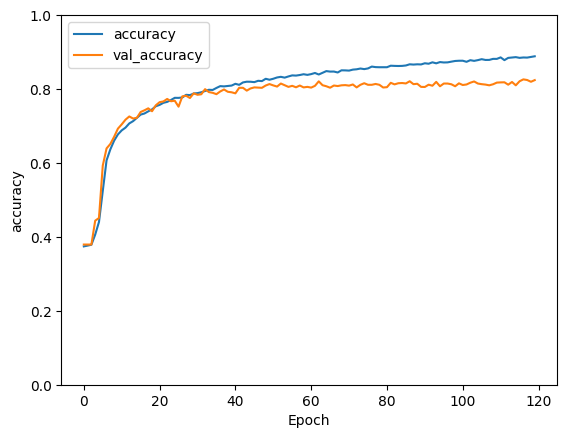

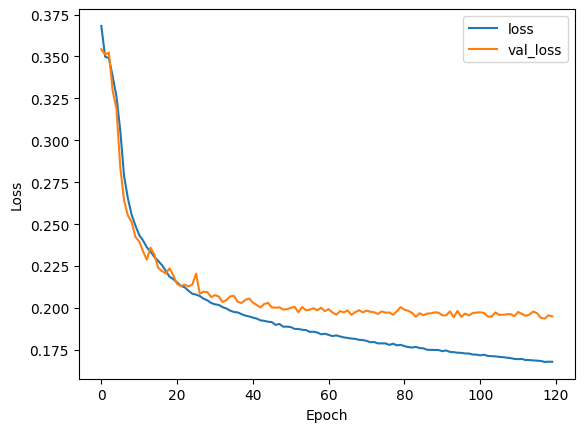

Model and weights are saved in separate files.


In [11]:
runModel()